In [1]:
import pandas as pd
import numpy as np
import re

from google_play_scraper import reviews, Sort

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')

stopwords_id = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aurora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # lower case
    text = text.lower()
    
    # hapus karakter non huruf
    text = re.sub(r'[^a-zA-Zàáâãäåèéêëìíîïòóôõöùúûüçñ ]', ' ', text)
    
    # hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    # hapus stopwords bahasa Indonesia
    words = text.split()
    words = [w for w in words if w not in stopwords_id]
    
    return " ".join(words)

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = " ".join([w for w in text.split() if w not in stopwords_id])
    return text

In [5]:
def get_playstore_reviews(app_id, n=200):
    print(f"📥 Mengambil {n} ulasan dari aplikasi: {app_id}")

    result, _ = reviews(
        app_id,
        lang="id",
        country="id",
        sort=Sort.NEWEST,
        count=n
    )

    df = pd.DataFrame(result)
    df = df[["content", "score"]]
    df.columns = ["ulasan", "rating"]

    # cleaning
    df["clean"] = df["ulasan"].apply(clean_text)

    return df


In [6]:
df_raw = get_playstore_reviews("com.whatsapp", 100)
df_raw.head()

📥 Mengambil 100 ulasan dari aplikasi: com.whatsapp


,ulasan,rating,clean
0,kena spam terus tolol,1,kena spam tolol
1,buruk,5,buruk
2,aku kasi rating ga full soalnya kapan hari aku...,4,kasi rating ga full telponan temen eh asik nya...
3,bagus,5,bagus
4,kalo kita mau. foto ada filter tiktok,5,kalo foto filter tiktok


In [7]:
def rating_to_label(r):
    if r <= 2:
        return "negatif"
    elif r == 3:
        return "netral"
    else:
        return "positif"

df_raw["label"] = df_raw["rating"].apply(rating_to_label)
df_raw.head()


,ulasan,rating,clean,label
0,kena spam terus tolol,1,kena spam tolol,negatif
1,buruk,5,buruk,positif
2,aku kasi rating ga full soalnya kapan hari aku...,4,kasi rating ga full telponan temen eh asik nya...,positif
3,bagus,5,bagus,positif
4,kalo kita mau. foto ada filter tiktok,5,kalo foto filter tiktok,positif


In [8]:
data = df_raw[df_raw["clean"].str.len() > 0]

X = data["clean"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\n", classification_report(y_test, y_pred))


Akurasi: 0.7

               precision    recall  f1-score   support

     negatif       0.75      0.43      0.55         7
      netral       0.00      0.00      0.00         1
     positif       0.69      0.92      0.79        12

    accuracy                           0.70        20
   macro avg       0.48      0.45      0.44        20
weighted avg       0.68      0.70      0.66        20



c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [9]:
def analyze_app_sentiment(app_id, n=200):
    df = get_playstore_reviews(app_id, n)
    if df.empty:
        print("Tidak ada ulasan.")
        return None
    
    df["sentimen_pred"] = model.predict(df["clean"])

    counts = df["sentimen_pred"].value_counts().reindex(
        ["positif", "netral", "negatif"],
        fill_value=0
    )

    print("📊 Hasil Sentimen:")
    print(counts)

    # grafik
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f"Sentimen untuk {app_id}")
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah Ulasan")
    plt.show()

    return df


In [12]:
result, _ = reviews(
    "com.instagram.android",
    lang="id",
    country="id",
    sort=Sort.NEWEST,
    count=20
)

df_test = pd.DataFrame(result)
df_test.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,57d4196f-25bb-4e8f-9b6b-d1def06755a2,I' am,https://play-lh.googleusercontent.com/a-/ALV-U...,paling annoying di instagram adalah ketika ada...,1,0,313.0.0.26.328,2025-12-10 17:09:48,None,None,313.0.0.26.328
1,c7868ae3-aadf-4495-be87-7881d53bd8a3,Nursiana Zen,https://play-lh.googleusercontent.com/a/ACg8oc...,bagikan dan menyimpan cerita dalam kehidupan,5,0,408.0.0.51.78,2025-12-09 23:12:54,None,None,408.0.0.51.78
2,03f46549-0cae-4d25-be64-9a7962c4a8cb,Saiful Jamil,https://play-lh.googleusercontent.com/a-/ALV-U...,pokok nya bagus 👍👍👍,5,0,408.0.0.51.78,2025-12-09 23:12:18,None,None,408.0.0.51.78
3,76aab472-8660-4f2b-9ab4-693fdb609639,hafid rismanwitaputra,https://play-lh.googleusercontent.com/a-/ALV-U...,fitur live hilang sudah komplain ke pihak inst...,1,1,408.0.0.51.78,2025-12-09 23:11:29,None,None,408.0.0.51.78
4,34af09ca-72cd-44e3-83a6-1b3be226ee37,Frides Wanto,https://play-lh.googleusercontent.com/a-/ALV-U...,media sosial yang baik.. tanda kutip..,5,0,408.0.0.51.78,2025-12-09 22:59:28,None,None,408.0.0.51.78


In [13]:
def get_playstore_reviews(app_id, n=200):
    print(f"📥 Mengambil {n} ulasan dari aplikasi: {app_id}")

    result, _ = reviews(
        app_id,
        lang="id",
        country="id",
        sort=Sort.NEWEST,
        count=n
    )

    df = pd.DataFrame(result)

    if df.empty:
        print("⚠ Tidak ada ulasan yang berhasil diambil.")
        return pd.DataFrame()

    # cek apakah kolom content dan score ada
    if "content" not in df.columns or "score" not in df.columns:
        print("⚠ Struktur data tidak sesuai. Kolom yang tersedia:", df.columns.tolist())
        print("➡ Penyebab: Aplikasi kemungkinan dilindungi (Instagram, Facebook, dll).")
        return pd.DataFrame()

    df = df[["content", "score"]]
    df.columns = ["ulasan", "rating"]
    df["clean"] = df["ulasan"].apply(clean_text)
    
    return df

In [ ]:
df_raw = get_playstore_reviews("com.bukalapak.android", 200)
df_raw.head()

📥 Mengambil 200 ulasan dari aplikasi: com.bukalapak.android


,ulasan,rating,clean
0,knpa nggak bisa masuk,5,knpa nggak masuk
1,mantap,3,mantap
2,sungguh malang sekali aplikasi Bukalapak sekar...,1,sungguh malang aplikasi bukalapak wkwkwk
3,udah ga bisa jualan. pada tahun 2015-2019 pada...,1,udah ga jualan padal mata pencaharian bangkrut...
4,bagus,5,bagus


In [16]:
df_raw = get_playstore_reviews("com.instagram.android", 200)
df_raw.head()

📥 Mengambil 200 ulasan dari aplikasi: com.instagram.android


,ulasan,rating,clean
0,paling annoying di instagram adalah ketika ada...,1,annoying instagram saran rekomendasi fitur hapus
1,bagikan dan menyimpan cerita dalam kehidupan,5,bagikan menyimpan cerita kehidupan
2,pokok nya bagus 👍👍👍,5,pokok nya bagus
3,fitur live hilang sudah komplain ke pihak inst...,1,fitur live hilang komplain instagram balesanny...
4,media sosial yang baik.. tanda kutip..,5,media sosial tanda kutip


In [17]:
def rating_to_label(score):
    if score <= 2:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

df_raw["label"] = df_raw["rating"].apply(rating_to_label)
df_raw.head()

,ulasan,rating,clean,label
0,paling annoying di instagram adalah ketika ada...,1,annoying instagram saran rekomendasi fitur hapus,negatif
1,bagikan dan menyimpan cerita dalam kehidupan,5,bagikan menyimpan cerita kehidupan,positif
2,pokok nya bagus 👍👍👍,5,pokok nya bagus,positif
3,fitur live hilang sudah komplain ke pihak inst...,1,fitur live hilang komplain instagram balesanny...,negatif
4,media sosial yang baik.. tanda kutip..,5,media sosial tanda kutip,positif


In [18]:
data = df_raw[df_raw["clean"].str.len() > 0]

X = data["clean"]
y = data["label"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("\n", classification_report(y_test, y_pred))


Akurasi: 0.6153846153846154

               precision    recall  f1-score   support

     negatif       0.33      0.17      0.22        12
      netral       0.00      0.00      0.00         1
     positif       0.67      0.85      0.75        26

    accuracy                           0.62        39
   macro avg       0.33      0.34      0.32        39
weighted avg       0.55      0.62      0.57        39



c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aurora\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [19]:
def analyze_app_sentiment(app_id, n=200):
    df = get_playstore_reviews(app_id, n)
    if df.empty:
        print("Tidak ada ulasan.")
        return None
    
    df["sentimen_pred"] = model.predict(df["clean"])

    counts = df["sentimen_pred"].value_counts().reindex(
        ["positif", "netral", "negatif"],
        fill_value=0
    )

    print("📊 Hasil Sentimen:", counts)

    # Grafik
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f"Sentimen Google Play untuk {app_id}")
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah Ulasan")
    plt.show()

    return df


📥 Mengambil 500 ulasan dari aplikasi: com.bukalapak.android
📊 Hasil Sentimen: sentimen_pred
positif    460
netral       0
negatif     40
Name: count, dtype: int64


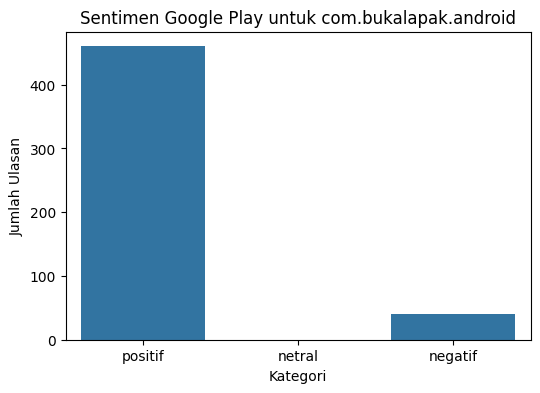

,ulasan,rating,clean,sentimen_pred
0,knpa nggak bisa masuk,5,knpa nggak masuk,positif
1,mantap,3,mantap,positif
2,sungguh malang sekali aplikasi Bukalapak sekar...,1,sungguh malang aplikasi bukalapak wkwkwk,positif
3,udah ga bisa jualan. pada tahun 2015-2019 pada...,1,udah ga jualan padal mata pencaharian bangkrut...,positif
4,bagus,5,bagus,positif


In [26]:
df_hasil = analyze_app_sentiment("com.bukalapak.android", 500)
df_hasil.head()

📥 Mengambil 500 ulasan dari aplikasi: com.instagram.android
📊 Hasil Sentimen: sentimen_pred
positif    416
netral       0
negatif     84
Name: count, dtype: int64


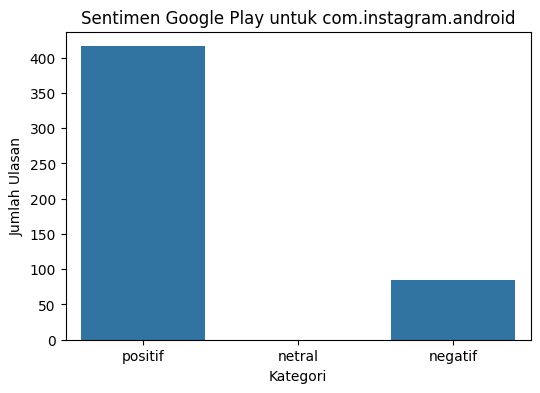

,ulasan,rating,clean,sentimen_pred
0,paling annoying di instagram adalah ketika ada...,1,annoying instagram saran rekomendasi fitur hapus,negatif
1,bagikan dan menyimpan cerita dalam kehidupan,5,bagikan menyimpan cerita kehidupan,positif
2,pokok nya bagus 👍👍👍,5,pokok nya bagus,positif
3,fitur live hilang sudah komplain ke pihak inst...,1,fitur live hilang komplain instagram balesanny...,negatif
4,media sosial yang baik.. tanda kutip..,5,media sosial tanda kutip,positif


In [27]:
df_hasil = analyze_app_sentiment("com.instagram.android", 500)
df_hasil.head()

In [28]:
def plot_review_length(df, app_id):
    df["panjang_kata"] = df["clean"].apply(lambda x: len(x.split()))

    plt.figure(figsize=(8,4))
    sns.histplot(df["panjang_kata"], bins=20, kde=True)
    plt.title(f"Distribusi Panjang Ulasan untuk {app_id}")
    plt.xlabel("Jumlah Kata")
    plt.ylabel("Frekuensi")
    plt.show()


In [29]:
def plot_pie_sentiment(df, app_id):
    counts = df["sentimen_pred"].value_counts().reindex(
        ["positif", "netral", "negatif"], fill_value=0
    )

    plt.figure(figsize=(6,6))
    plt.pie(counts.values, labels=counts.index, autopct="%1.1f%%", startangle=140)
    plt.title(f"Diagram Pie Sentimen untuk {app_id}")
    plt.show()

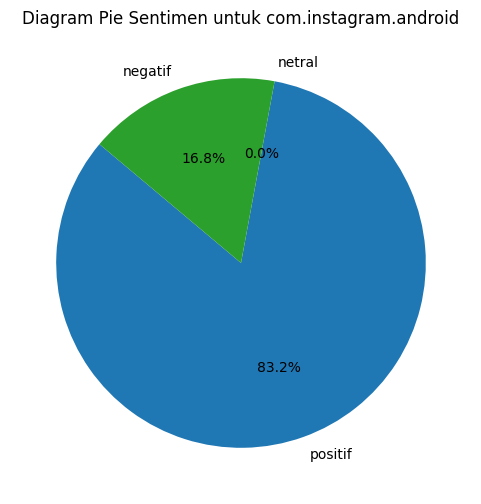

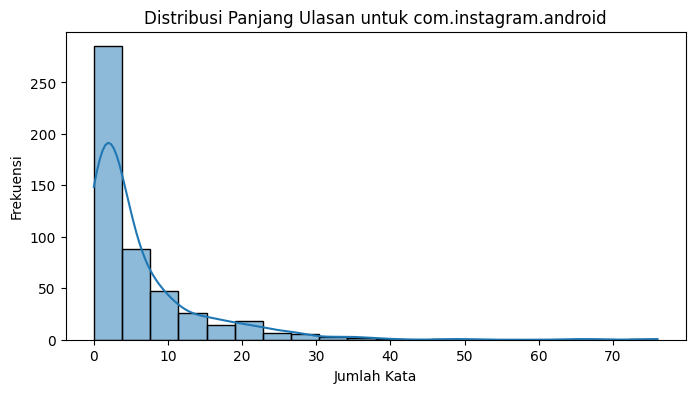

In [30]:
plot_pie_sentiment(df_hasil, "com.instagram.android")
plot_review_length(df_hasil, "com.instagram.android")

In [31]:
from wordcloud import WordCloud

def plot_wordcloud(df, sentiment_type, app_id):
    text = " ".join(df[df["sentimen_pred"] == sentiment_type]["clean"])
    
    if len(text) < 5:
        print(f"Tidak ada cukup teks untuk sentimen {sentiment_type}")
        return

    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud Sentimen {sentiment_type.capitalize()} - {app_id}")
    plt.show()

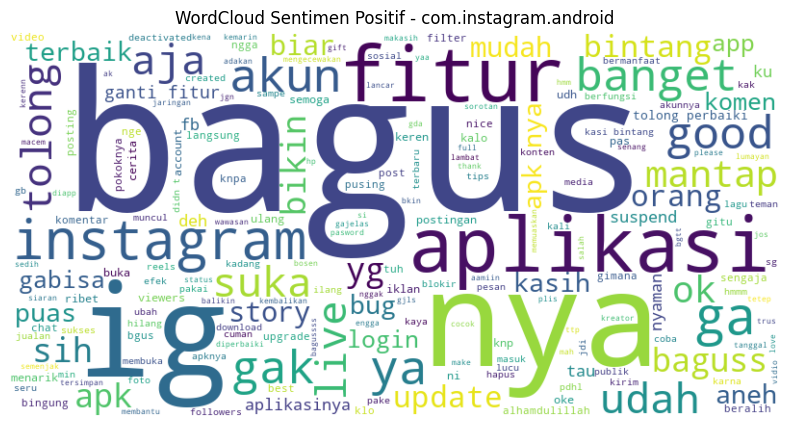

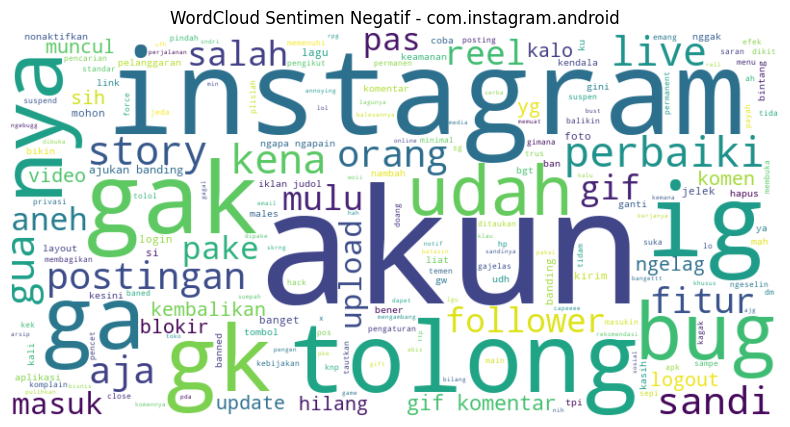

In [32]:
plot_wordcloud(df_hasil, "positif", "com.instagram.android")
plot_wordcloud(df_hasil, "negatif", "com.instagram.android")

In [33]:
def plot_mean_rating(df, app_id):
    mean_scores = df.groupby("sentimen_pred")["rating"].mean().reindex(
        ["positif", "netral", "negatif"], fill_value=0
    )

    plt.figure(figsize=(6,4))
    sns.barplot(x=mean_scores.index, y=mean_scores.values)
    plt.title(f"Rata-rata Rating Berdasarkan Sentimen – {app_id}")
    plt.xlabel("Kategori Sentimen")
    plt.ylabel("Rata-rata Rating")
    plt.ylim(0,5)
    plt.show()

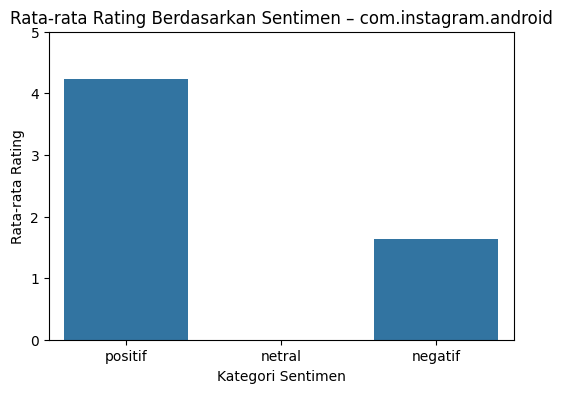

In [34]:
plot_mean_rating(df_hasil, "com.instagram.android")

In [35]:
def plot_boxplot_rating(df, app_id):
    plt.figure(figsize=(7,5))
    sns.boxplot(data=df, x="sentimen_pred", y="rating")
    plt.title(f"Distribusi Rating Berdasarkan Sentimen – {app_id}")
    plt.xlabel("Sentimen")
    plt.ylabel("Rating")
    plt.show()


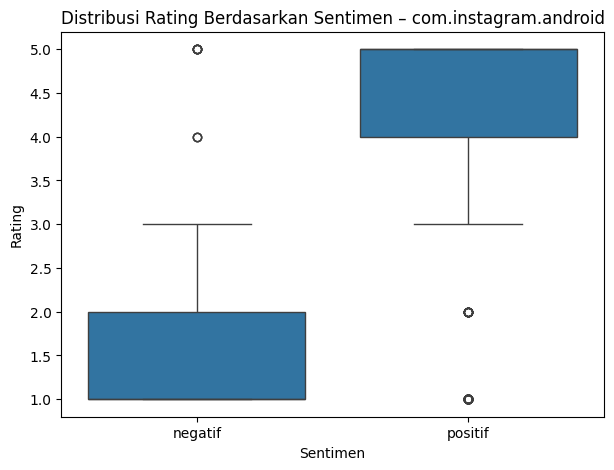

In [36]:
plot_boxplot_rating(df_hasil, "com.instagram.android")
